In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# naložimo podatke in jih shranimo v DataFrame data
data = pd.read_csv("Loan_Default.csv")

# odstranimo ID in year stolpec, saj nimata nobene informacijske vrednosti
data.drop(["ID", "year"], axis = 1, inplace = True)

In [3]:
# podatke razdelimo na kategorične in numerične
numerical_variables = [
    "loan_amount", "rate_of_interest", "Interest_rate_spread", "Upfront_charges",
    "property_value", "income", "Credit_Score", "LTV", "dtir1"
]
categorical_variables = [var for var in data.columns if var not in numerical_variables][:-1]

num = data[numerical_variables]
cat = data[categorical_variables]
target = data["Status"]

In [4]:
# rate_of_interest + Interest_rate_spread = real_rate
num["real_rate"] = num["rate_of_interest"] + num["Interest_rate_spread"]
num = num.drop(["rate_of_interest", "Interest_rate_spread"], axis = 1)

# odstranimo LTV saj je 100 * loan_amount / property_value
num = num.drop(["LTV"], axis = 1)

# odstranimo Credit_Score saj je enakomerno zvezno porazdeljena
num = num.drop(["Credit_Score"], axis = 1)

C:\Users\uporabnik\AppData\Local\Temp\ipykernel_10976\3248769621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num["real_rate"] = num["rate_of_interest"] + num["Interest_rate_spread"]


In [5]:
# imputiramo manjkajoče vrednosti pri numeričnih spremenljivkah
ki = KNNImputer()
num = pd.DataFrame(ki.fit_transform(num), columns = num.columns, index = num.index)

In [6]:
# transformiramo numerične spremenljivke tako da bodo centralizirane in čim bolj "normalne"
# oprabimo Yeo-Johnson transformacijo
pt = PowerTransformer(method = 'yeo-johnson')
num = pd.DataFrame(pt.fit_transform(num), columns = num.columns)

In [7]:
# odstranim outlierje 
num["dist"] = num.pow(2).sum(axis = 1)**(1/2)
threshold = np.percentile(num["dist"], 99)
num = num[num["dist"] <= threshold]
num.drop("dist", axis = 1, inplace = True)

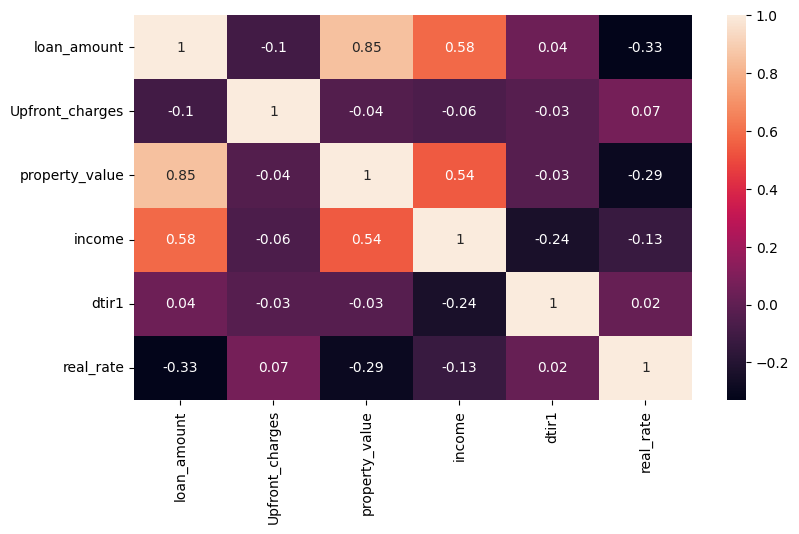

In [8]:
# korelacijska matrika za numeričnih spremeljivk
plt.figure(figsize=(9, 5))
sns.heatmap(np.round(num.corr(), 2), annot = True)
plt.show()

In [9]:
# odstranimo vrstice, ki vsebuje NaN vrednosti, glede na to da jih je zelo malo 
cat = cat.dropna(
    subset=["loan_limit", "approv_in_adv", "loan_purpose", "Neg_ammortization", "age", "submission_of_application", "term"]
)

In [10]:
for var in cat.columns:
    values = cat[var].value_counts()
    print(var, values.iloc[0] / values.iloc[1])

loan_limit 13.749666974075213
Gender 1.019655652866242
approv_in_adv 5.274169645192224
loan_type 5.50605071554105
loan_purpose 1.0100113935635704
Credit_Worthiness 21.808112818887658
open_credit 266.05380333951763
business_or_commercial 6.2278182274667335
term 9.356314535345513
Neg_ammortization 9.03429766469153
interest_only 20.087313214181073
lump_sum_payment 41.53605200945626
construction_type 4360.878787878788
occupancy_type 18.982416335791264
Secured_by 4360.878787878788
total_units 99.04748603351955
credit_type 1.098016637683884
co-applicant_credit_type 1.001891437074948
age 1.0585905576161438
submission_of_application 1.8186339782251115
Region 1.1693743742127192
Security_Type 4360.878787878788


In [11]:
# odstranimo spremenljivke, katere razmerje med prvo in drugo najbolj pogosto vrednostjo je > 20
cat = cat.drop(
    ["Credit_Worthiness", "open_credit", "interest_only", "lump_sum_payment", "construction_type",
     "occupancy_type", "Secured_by", "total_units", "Security_Type"],
    axis = 1
)

In [12]:
# pretvorimo kategorične vrednosti v numerične
le = LabelEncoder()
for i in range(len(cat.columns)):
    cat.iloc[:, i] = le.fit_transform(cat.iloc[:, i])

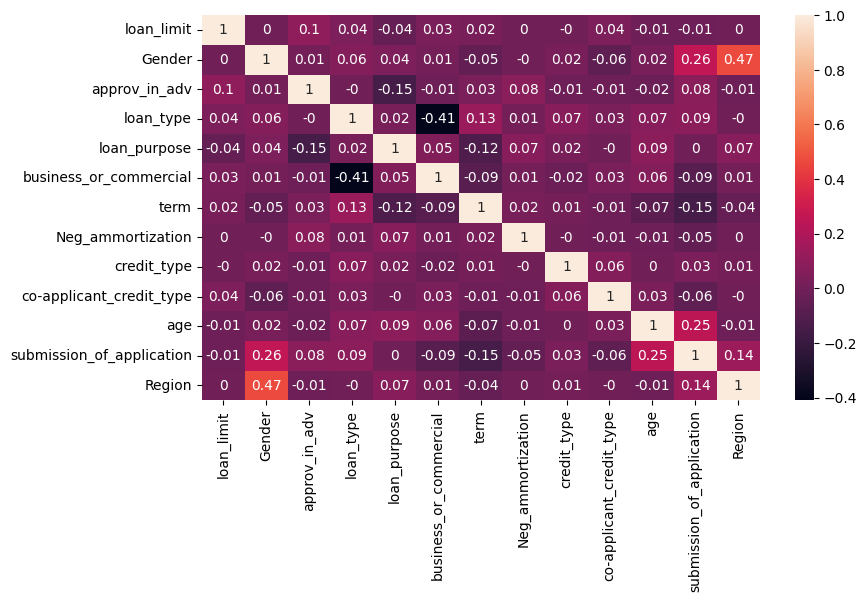

In [13]:
# korelacijska matrika za kategorične spremeljivk
plt.figure(figsize=(9, 5))
sns.heatmap(np.round(cat.corr(), 2), annot = True)
plt.show()

In [14]:
# združimo urejene podatke v novo podatkovno množico
df = pd.concat([num, cat, target], axis = 1).dropna()

In [15]:
df.drop("term", axis = 1, inplace = True)

In [25]:
# razdelimo podatke na napovedno spremenljivko y in podatke X
X = df[df.columns.difference(["Status"])].to_numpy()
y = df["Status"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [26]:
# ker je ciljna spremenljivka neuravnotežena uporabimo 4 različne metode reševanja tega problema
rus = RandomUnderSampler(random_state=9)
tl = TomekLinks()
sm = SMOTE(random_state=9)
smt = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"))

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

sample = {
    "rus": [X_train_rus, y_train_rus],
    "tl": [X_train_tl, y_train_tl],
    "sm": [X_train_sm, y_train_sm],
    "smt": [X_train_smt, y_train_smt]
}

In [29]:
# za model bom uporabim XGBClassifier(), ki spada med najboljše
model = XGBClassifier()
for key, value in sample.items():
    print(key)
    model.fit(value[0], value[1])
    y_pred = model.predict(X_test)
    cr = classification_report(y_pred = y_pred, y_true = y_test, output_dict = True)
    print(cr["0"])
    print(cr["1"])
    print("")

rus
{'precision': 0.9643014113395517, 'recall': 0.91437832831674, 'f1-score': 0.9386765544780377, 'support': 21595.0}
{'precision': 0.769595015576324, 'recall': 0.8941653395106414, 'f1-score': 0.8272167157781944, 'support': 6907.0}

tl
{'precision': 0.9400197984161267, 'recall': 0.9673998610789535, 'f1-score': 0.9535133161413999, 'support': 21595.0}
{'precision': 0.8878623765530423, 'recall': 0.8070073838135225, 'f1-score': 0.8455062571103527, 'support': 6907.0}

sm
{'precision': 0.9404320708668534, 'recall': 0.9635563787913869, 'f1-score': 0.9518538002332975, 'support': 21595.0}
{'precision': 0.8765683814303639, 'recall': 0.8091790936730853, 'f1-score': 0.8415267635323346, 'support': 6907.0}

smt
{'precision': 0.9417546084514697, 'recall': 0.9628617735586942, 'f1-score': 0.952191235059761, 'support': 21595.0}
{'precision': 0.8751362291763973, 'recall': 0.8138120747068192, 'f1-score': 0.8433608402100525, 'support': 6907.0}

